# Project 6

In [1]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv', usecols=['time_iso8601', 'sum_cases'], parse_dates=['time_iso8601'])
df.columns = ['ds', 'y']
df['ds'] = df['ds'].dt.tz_localize(None)
df.tail()

,ds,y
282,2020-12-09 17:00:00,1256888
283,2020-12-10 17:00:00,1285406
284,2020-12-11 17:00:00,1311143
285,2020-12-12 17:00:00,1329498
286,2020-12-13 17:00:00,1337078


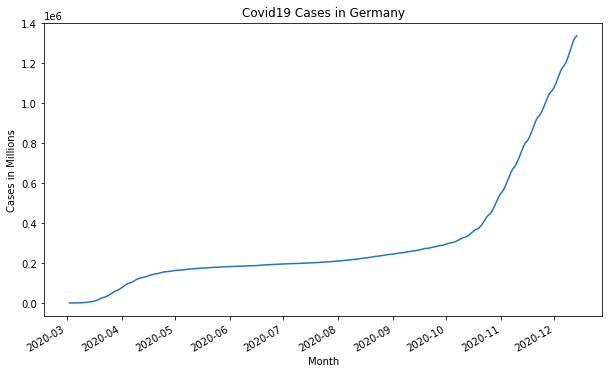

In [3]:
df.plot(x='ds', y='y', figsize=(10,6), title='Covid19 Cases in Germany', xlabel='Month', ylabel='Cases in Millions', legend=False);
plt.savefig('p6_cases.eps', format='eps')

In [4]:
# use last 14 days as test set
df_train = df.iloc[:-14]
test = df[-14:]
df_train.tail()

,ds,y
268,2020-11-25 17:00:00,995815
269,2020-11-26 17:00:00,1018612
270,2020-11-27 17:00:00,1038747
271,2020-11-28 17:00:00,1053676
272,2020-11-29 17:00:00,1062496


# Additive Model

In [5]:
m = Prophet()
m.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [6]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
282,2020-12-09 17:00:00
283,2020-12-10 17:00:00
284,2020-12-11 17:00:00
285,2020-12-12 17:00:00
286,2020-12-13 17:00:00


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
282,2020-12-09 17:00:00,1.122284e+06,1.091460e+06,1.153658e+06
283,2020-12-10 17:00:00,1.136745e+06,1.105043e+06,1.169155e+06
284,2020-12-11 17:00:00,1.150991e+06,1.119061e+06,1.182513e+06
285,2020-12-12 17:00:00,1.163955e+06,1.131851e+06,1.193831e+06
286,2020-12-13 17:00:00,1.177713e+06,1.145928e+06,1.213735e+06


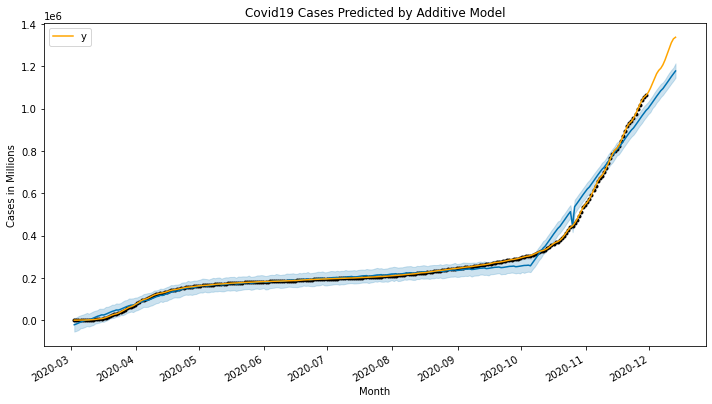

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
fig1 = m.plot(forecast, ax=ax)
df.plot(x='ds', y='y', ax=ax, color='orange', title='Covid19 Cases Predicted by Additive Model', xlabel='Month', ylabel='Cases in Millions');
plt.savefig('p6_decomp_pred.png')

In [9]:
#Mean absolute percentage error
def mape(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [10]:
pred = np.array(forecast.iloc[-14:]['yhat'])
print('\nTest MSE: ', mean_squared_error(test['y'], pred))


Test MSE:  15029670011.487803


In [11]:
print('\nTest MAPE:% ', mape(test['y'], pred))


Test MAPE:%  9.733652962675944


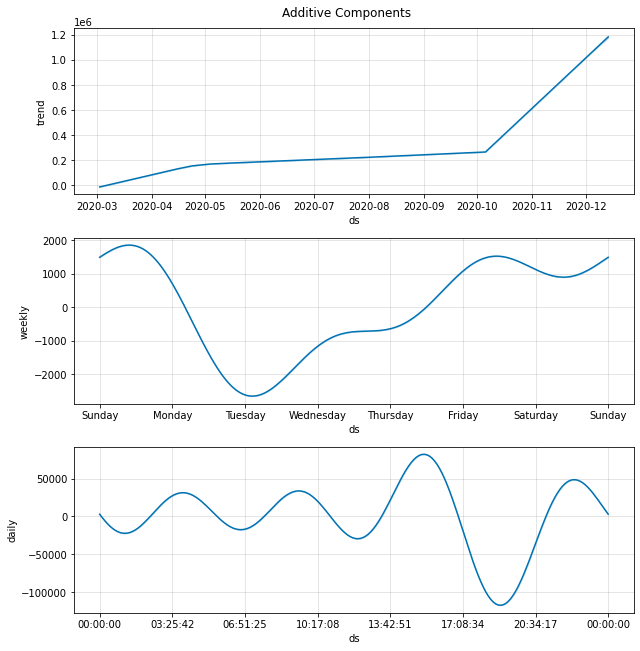

In [12]:
fig2 = m.plot_components(forecast)
plt.suptitle('Additive Components', y=1, x=0.54)
plt.tight_layout()
#plt.savefig('p6_comps.eps', format='eps')
plt.show()

In [13]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

# Changepoint Analysis

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


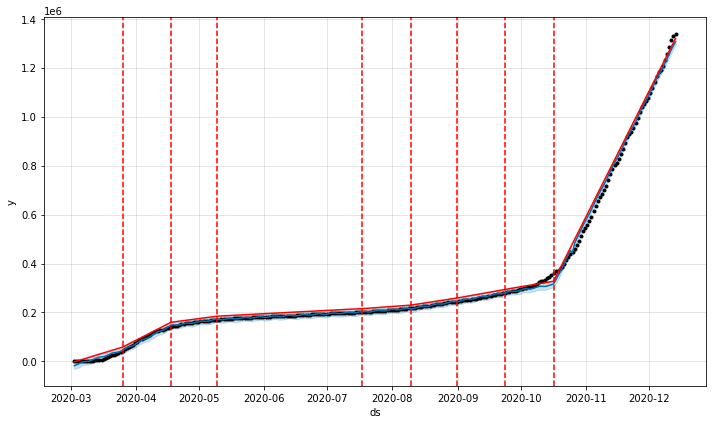

In [14]:
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(changepoint_prior_scale=0.1,n_changepoints=10)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


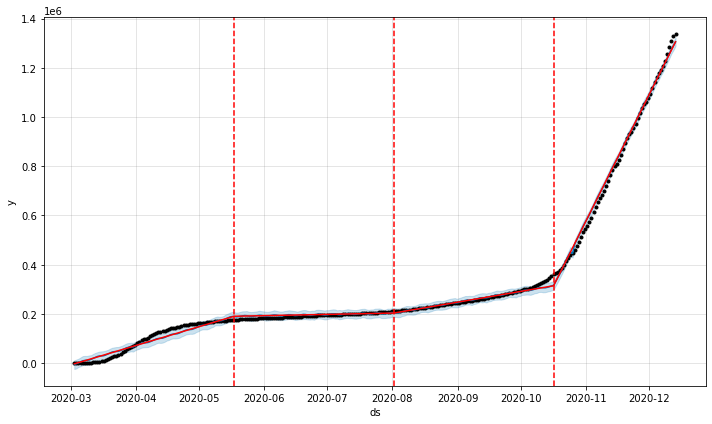

In [15]:
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(changepoint_prior_scale=0.1,n_changepoints=3)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Autoregressive Model

In [16]:
! pip install statsmodels --upgrade   # This is new, wouldn't work without it for me.
from statsmodels.tsa.ar_model import AutoReg

# create 1d arrays from dataframe
train = np.array(df_train['y'])
test = np.array(df.iloc[-14:]['y'])

lags = np.arange(30)
mses = []

for p in lags:
  # fit AR(p) model
  model = AutoReg(train, lags=p, old_names=True)
  model_fit = model.fit()

  # make predictions
  predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

  mses.append(mean_squared_error(test, predictions))
  #print('\np = {} \t Test MSE: %.1f'.format(p) % mse)

print('\nLowest MSE is %.1f with p = {}.'.format(np.argmin(mses)) % min(mses))
# I'm not sure why, when I ran this again instead of p=18, I got p=7.
# At first AutoReg wouldn't run at all for me, but then I upgraded the
# statsmodels and it worked. Probably we're running a different version
# of statsmodels. Since p=18 is really good already, I'm not going to
# change it anymore.

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.1)

Lowest MSE is 8729739.8 with p = 26.


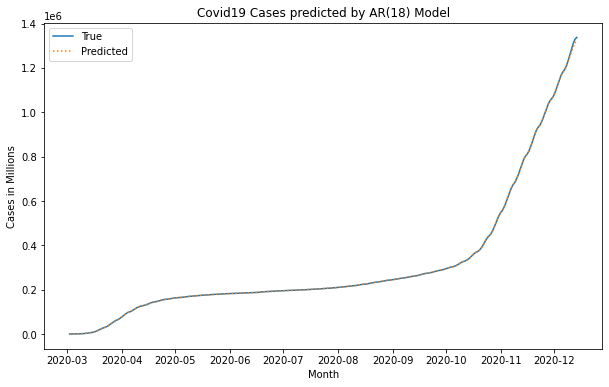

In [17]:
# fit AR(p) model
model = AutoReg(train, lags=18, old_names=True)
model_fit = model.fit()

# make predictions
predictions = model_fit.predict(start=18, end=len(train)+len(test)-1, dynamic=False)

# create array of same size for plotting
y_pred = np.hstack([train[:18],predictions])

plt.figure(figsize=(10,6))
plt.plot(df['ds'], df['y'], label='True')
plt.plot(df['ds'], y_pred, label='Predicted', linestyle='dotted')
plt.title('Covid19 Cases predicted by AR(18) Model')
plt.ylabel('Cases in Millions')
plt.xlabel('Month')
plt.legend()
#plt.savefig('p6_ar.eps', format='eps')
plt.show()

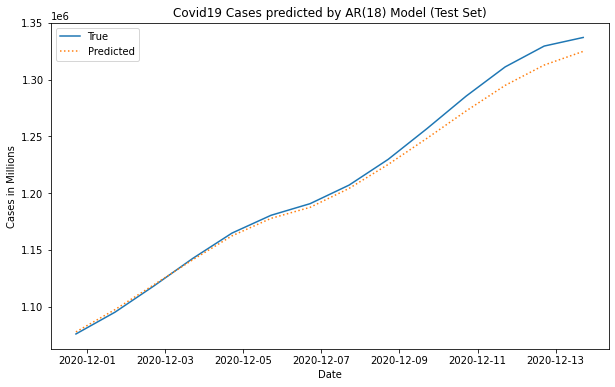

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df['ds'][-14:], df['y'][-14:], label='True')
plt.plot(df['ds'][-14:], y_pred[-14:], label='Predicted', linestyle='dotted')
plt.title('Covid19 Cases predicted by AR(18) Model (Test Set)')
plt.ylabel('Cases in Millions')
plt.xlabel('Date')
plt.legend()
#plt.savefig('p6_ar_test.eps', format='eps')
plt.show()

In [19]:
print('\nTest MAPE:% ', mape(df['y'][-14:], y_pred[-14:]))


Test MAPE:%  0.5002612956309183


# LSTM

In [20]:
!pip install tensorflow==1.9.0
!pip install keras==2.2.0

In [21]:
import pandas as pd
import numpy as np
import itertools
import datetime 
#manipulating data and basic python libraries

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
#Preprocessing data and metrics for error evaluation

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, LSTM, ReLU
from keras.optimizers import Adam
from tensorflow.keras.callbacks import  Callback, EarlyStopping, ReduceLROnPlateau,TensorBoard
#Tensorflow as our deep learning back end

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(palette = 'Set2',style='dark',font=['simhei', 'Arial'])
#Visualization

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

In [22]:
import keras.backend as K
sess = tf.Session()
K.set_session(sess)

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv', parse_dates=['time_iso8601'])

In [24]:
df.rename(columns={'time_iso8601': 'Date'}, inplace=True)
#pd.to_datetime(df.time_iso8601.str.slice(0, 10) , format='%Y-%m-%d')
col_names = df.columns[1:17]

# Finding daily new cases
for i in range(1,18,1):
  df.iloc[:,i] = df.iloc[:,i].diff().fillna(df.iloc[:,i].iloc[0])


In [25]:
col_names

Index(['DE-BB', 'DE-BE', 'DE-BW', 'DE-BY', 'DE-HB', 'DE-HE', 'DE-HH', 'DE-MV',
       'DE-NI', 'DE-NW', 'DE-RP', 'DE-SH', 'DE-SL', 'DE-SN', 'DE-ST', 'DE-TH'],
      dtype='object')

In [26]:
sns.set(palette = 'Dark2',style='darkgrid')

def pltState(*argv):
    f, ax=plt.subplots(figsize=(20,10))
    labels=argv
    for a in argv: 
        state=df[a]
        state.reset_index(inplace=True,drop=True)      
        plt.plot(df['Date'],df[a],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        ax.set(title='Evolution of the number of cases',xlabel='Date',ylabel='Number of daily cases')

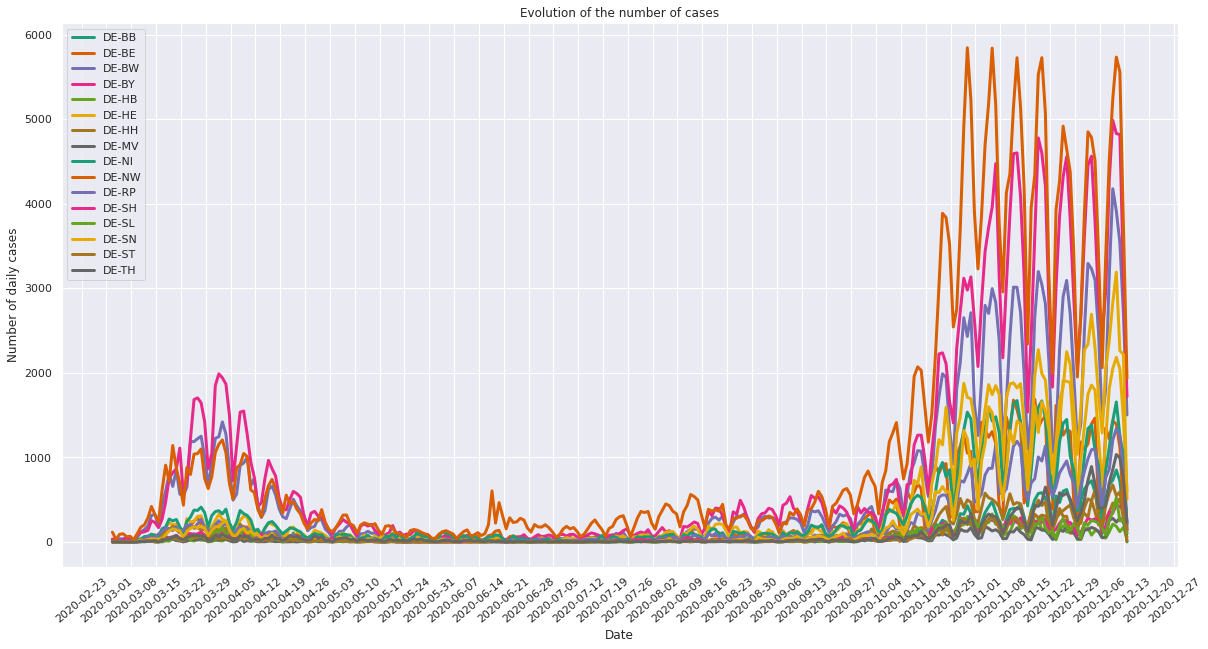

In [27]:
pltState('DE-BB', 'DE-BE', 'DE-BW', 'DE-BY', 'DE-HB', 'DE-HE', 'DE-HH', 'DE-MV',
       'DE-NI', 'DE-NW', 'DE-RP', 'DE-SH', 'DE-SL', 'DE-SN', 'DE-ST', 'DE-TH')

In [28]:
#Mean absolute percentage error
def mape(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [29]:
#Scale and split the data
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df['sum_cases'].values.reshape(-1,1).astype('float32'))

train = scaled[0:258]
test = scaled[259:]


In [30]:
#Transform our ts to a usable df with lookback 
#This means we make our ts a supervised learning modelizable df
def lookBack(ts, look_back=14):
    X=list()
    Y=list()
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back), 0]
        X.append(a)
        Y.append(ts[i + look_back, 0])
    return np.array(X), np.array(Y)

trainX, trainY = lookBack(train)
testX, testY = lookBack(test)

In [31]:
#Reshape our data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#Modeling and fitting
model = Sequential()

model.add(LSTM(516, dropout=0.2, input_shape=(1,14), activation='relu'))
model.add(Dense(1))

early_stop=EarlyStopping(monitor='val_loss', patience=15, verbose=0)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

history=model.fit(trainX,trainY, epochs = 50, batch_size = 12,validation_data=(testX, testY), 
                  shuffle=False, callbacks=[early_stop])
model.summary()

Train on 244 samples, validate on 14 samples
Epoch 1/50
244/244 [==============================] - 2s 8ms/step - loss: 0.0686 - acc: 0.0000e+00 - val_loss: 0.2790 - val_acc: 0.0000e+00
Epoch 2/50
244/244 [==============================] - 1s 4ms/step - loss: 0.0474 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0714
Epoch 3/50
244/244 [==============================] - 1s 4ms/step - loss: 0.0364 - acc: 0.0000e+00 - val_loss: 0.2009 - val_acc: 0.0714
Epoch 4/50
244/244 [==============================] - 1s 4ms/step - loss: 0.0389 - acc: 0.0000e+00 - val_loss: 0.1753 - val_acc: 0.0714
Epoch 5/50
244/244 [==============================] - 1s 5ms/step - loss: 0.0389 - acc: 0.0000e+00 - val_loss: 0.1643 - val_acc: 0.0714
Epoch 6/50
244/244 [==============================] - 1s 4ms/step - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.1638 - val_acc: 0.0714
Epoch 7/50
244/244 [==============================] - 1s 4ms/step - loss: 0.0438 - acc: 0.0000e+00 - val_loss: 0.1631 - val_acc: 0.0714

Mean absolute error:  0.10815916
Mean absolute  percentage error: % 36.74584925174713


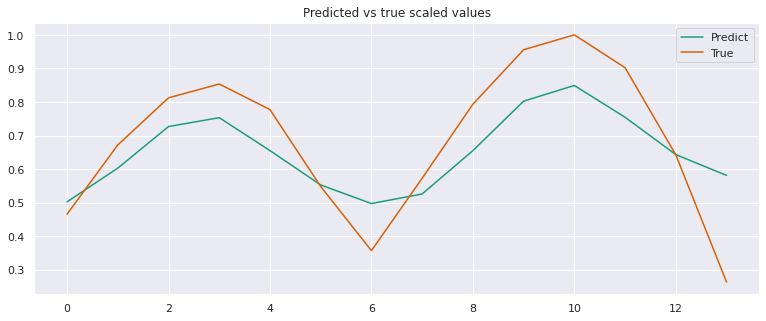

In [32]:
#plotting our resutls and the error of our scaled data
pred=model.predict(testX)
f,ax=plt.subplots(figsize=(13,5))
plt.plot(pred, label='Predict')
plt.plot(testY, label='True')
plt.legend()
plt.title('Predicted vs true scaled values')

print('Mean absolute error: ',mean_absolute_error(testY,pred))
print('Mean absolute  percentage error: %',mape(testY,pred))

Mean absolute error:  3075.2896
Mean absolute  percentage error: % 20.56436836719513
R^2: 0.6183902097890139


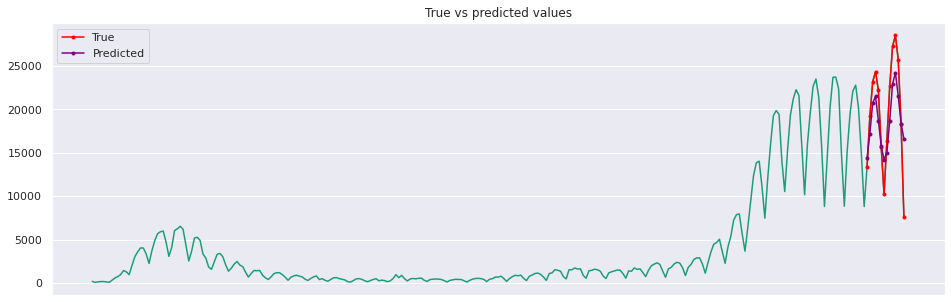

In [33]:
#reversing the scaling
predictions= scaler.inverse_transform(pred.reshape(-1, 1))
test_val = scaler.inverse_transform(testY.reshape(-1, 1))
#getting the dates back
dates = df['Date'].tail(len(testX)).index
#reshaping
predictions = predictions.reshape(len(predictions))
test_val = test_val.reshape(len(test_val))

#plotting the data
f, ax=plt.subplots(figsize=(16,5))
plt.plot(df['sum_cases'])
plt.plot(dates, test_val, label= 'True', c='red',marker='.')
plt.plot(dates, predictions, label= 'Predicted', marker='.' ,c='purple')
plt.xticks([])
plt.title('True vs predicted values')
a=plt.legend()
print('Mean absolute error: ',mean_absolute_error(test_val,predictions))
print('Mean absolute  percentage error: %',mape(test_val,predictions))
print('R^2:',r2_score(test_val,predictions))